# CV Assignment 2
### Name: Pothugunta Venkat
### Roll No: 2020101076

## Q1

### Loading MNIST dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze()) # changing shape from (1, 28, 28) to (28, 28)
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

ModuleNotFoundError: No module named 'torch'

### 1.1 Implementing SIFT-BoVW-SVM

In [ ]:
import numpy as np
import cv2

# Initialize SIFT detector
sift = cv2.SIFT_create()

sift_features = []
for images, labels in trainloader:
    images = images.numpy() * 255  # Convert to numpy array and scale to 0-255
    images = images.astype(np.uint8)  # Convert to uint8
    for img in images:
        kp, des = sift.detectAndCompute(img, None) # Compute SIFT features
        if des is not None:
            sift_features.append(des)

sift_features = np.concatenate(sift_features, axis=0)
print("SIFT features shape:", sift_features.shape)

SIFT features shape: (469496, 128)


In [ ]:
# Generating bag of words
from sklearn.cluster import KMeans

bag_of_words = KMeans(n_clusters=20, random_state=0, n_init="auto")
bag_of_words.fit(sift_features)

KMeans(n_clusters=20, random_state=0)

In [ ]:
# Generate histograms for given image
def generate_histogram(img, bag_of_words):
    kp, des = sift.detectAndCompute(img, None)
    if des is None:
        return np.zeros(bag_of_words.n_clusters)
    pred = bag_of_words.predict(des)
    hist, _ = np.histogram(pred, bins=range(bag_of_words.n_clusters + 1))   
    return hist

print("Histogram for an image:", generate_histogram(images[0], bag_of_words))    

Histogram for an image: [0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 3 2 0]


In [ ]:
# Train and test set for SVM
X_train = []
y_train = []
for images, labels in trainloader:
    images = images.numpy() * 255
    images = images.astype(np.uint8)
    for img, label in zip(images, labels):
        hist = generate_histogram(img, bag_of_words)
        X_train.append(hist)
        y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for images, labels in testloader:
    images = images.numpy() * 255
    images = images.astype(np.uint8)
    for img, label in zip(images, labels):
        hist = generate_histogram(img, bag_of_words)
        X_test.append(hist)
        y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60000, 20)
y_train shape: (60000,)
X_test shape: (10000, 20)
y_test shape: (10000,)


In [ ]:
# Train SVM
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [ ]:
from sklearn.metrics import classification_report

# Test SVM
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

# report in a table
print(classification_report(y_test, y_pred))

Accuracy: 0.5479
              precision    recall  f1-score   support

           0       0.59      0.71      0.64       980
           1       0.84      0.97      0.90      1135
           2       0.45      0.38      0.41      1032
           3       0.47      0.46      0.46      1010
           4       0.55      0.49      0.52       982
           5       0.43      0.40      0.41       892
           6       0.37      0.29      0.33       958
           7       0.52      0.63      0.57      1028
           8       0.61      0.55      0.58       974
           9       0.50      0.53      0.51      1009

    accuracy                           0.55     10000
   macro avg       0.53      0.54      0.53     10000
weighted avg       0.54      0.55      0.54     10000



### 1.2 Sweeping number of clusters value

In [ ]:
num_of_clusters = [10, 20, 50, 100, 200, 500]
for n in num_of_clusters:
    bag_of_words = KMeans(n_clusters=n, random_state=0, n_init="auto")
    bag_of_words.fit(sift_features)
    X_train = []
    y_train = []
    for images, labels in trainloader:
        images = images.numpy() * 255
        images = images.astype(np.uint8)
        for img, label in zip(images, labels):
            hist = generate_histogram(img, bag_of_words)
            X_train.append(hist)
            y_train.append(label)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = []
    y_test = []
    for images, labels in testloader:
        images = images.numpy() * 255
        images = images.astype(np.uint8)
        for img, label in zip(images, labels):
            hist = generate_histogram(img, bag_of_words)
            X_test.append(hist)
            y_test.append(label)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    print("Accuracy for", n, "clusters:", accuracy)
    print(classification_report(y_test, y_pred))

Accuracy for 10 clusters: 0.4565
              precision    recall  f1-score   support

           0       0.48      0.71      0.58       980
           1       0.84      0.97      0.90      1135
           2       0.38      0.27      0.31      1032
           3       0.34      0.36      0.35      1010
           4       0.45      0.35      0.39       982
           5       0.26      0.18      0.21       892
           6       0.29      0.21      0.24       958
           7       0.41      0.60      0.49      1028
           8       0.48      0.36      0.41       974
           9       0.40      0.45      0.42      1009

    accuracy                           0.46     10000
   macro avg       0.43      0.45      0.43     10000
weighted avg       0.44      0.46      0.44     10000

Accuracy for 20 clusters: 0.5479
              precision    recall  f1-score   support

           0       0.59      0.71      0.64       980
           1       0.84      0.97      0.90      1135
           2

We observe that the accuracy significantly increases as we increase the cluster size.

### 1.3 Results for 6 different hyperparameter settings

In [ ]:
# changing parameters of sift

default = {             ## These are the default parameters used in sift
    'nfeatures': 0,
    'nOctaveLayers': 3,
    'contrastThreshold': 0.04,
    'edgeThreshold': 10.0,
    'sigma': 1.6,
}

params1 = {
    'nfeatures': 0,
    'nOctaveLayers': 6,
    'contrastThreshold': 0.04,
    'edgeThreshold': 10.0,
    'sigma': 1.6,
}

params2 = {
    'nfeatures': 0,
    'nOctaveLayers': 10,
    'contrastThreshold': 0.04,
    'edgeThreshold': 10.0,
    'sigma': 1.6,
}

params3 = {
    'nfeatures': 0,
    'nOctaveLayers': 3,
    'contrastThreshold': 0.08,
    'edgeThreshold': 10.0,
    'sigma': 1.6,
}

params4 = {
    'nfeatures': 0,
    'nOctaveLayers': 3,
    'contrastThreshold': 0.16,
    'edgeThreshold': 10.0,
    'sigma': 1.6,
}

params5 = {
    'nfeatures': 0,
    'nOctaveLayers': 3,
    'contrastThreshold': 0.04,
    'edgeThreshold': 5.0,
    'sigma': 1.6,
}

params6 = {
    'nfeatures': 0,
    'nOctaveLayers': 3,
    'contrastThreshold': 0.04,
    'edgeThreshold': 3.0,
    'sigma': 1.6,
}

# train and test sift features for different parameters
params = [params1, params2, params3, params4, params5, params6]
for param in params:
    sift = cv2.SIFT_create()
    sift.setNFeatures(param['nfeatures'])
    sift.setNOctaveLayers(param['nOctaveLayers'])
    sift.setContrastThreshold(param['contrastThreshold'])
    sift.setEdgeThreshold(param['edgeThreshold'])
    sift.setSigma(param['sigma'])
    
    sift_features = []
    for images, labels in trainloader:
        images = images.numpy() * 255
        images = images.astype(np.uint8)
        for img in images:
            kp, des = sift.detectAndCompute(img, None)
            if des is not None:
                sift_features.append(des)

    sift_features = np.concatenate(sift_features, axis=0)
    print("SIFT features shape:", sift_features.shape)

    bag_of_words = KMeans(n_clusters=20, random_state=0, n_init="auto")
    bag_of_words.fit(sift_features)

    X_train = []
    y_train = []
    for images, labels in trainloader:
        images = images.numpy() * 255
        images = images.astype(np.uint8)
        for img, label in zip(images, labels):
            hist = generate_histogram(img, bag_of_words)
            X_train.append(hist)
            y_train.append(label)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = []
    y_test = []
    for images, labels in testloader:
        images = images.numpy() * 255
        images = images.astype(np.uint8)
        for img, label in zip(images, labels):
            hist = generate_histogram(img, bag_of_words)
            X_test.append(hist)
            y_test.append(label)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    print("Accuracy for", param, ":", accuracy)
    print(classification_report(y_test, y_pred))

SIFT features shape: (624113, 128)
Accuracy for {'nfeatures': 0, 'nOctaveLayers': 6, 'contrastThreshold': 0.04, 'edgeThreshold': 10.0, 'sigma': 1.6, 'contrastEnhanced': False, 'upright': False} : 0.6129
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       980
           1       0.92      0.96      0.94      1135
           2       0.48      0.43      0.45      1032
           3       0.50      0.50      0.50      1010
           4       0.61      0.63      0.62       982
           5       0.50      0.46      0.48       892
           6       0.48      0.40      0.43       958
           7       0.59      0.66      0.62      1028
           8       0.72      0.65      0.68       974
           9       0.57      0.58      0.58      1009

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.61      0.61      0.61     10000

SIFT features shape: (957357, 128)
Acc

## 2 CNNs and Transformers

### 2.1 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

def train_model(model, trainloader, testloader, criterion, optimizer, epochs, device):
    model.train()
    model.to(device)
    criterion.to(device)
    
    for epoch in range(epochs):  
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as model
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:  
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
        train_accuracy = 100 * correct / total
        print('Epoch %d: Training Accuracy: %.2f %%' % (epoch + 1, train_accuracy))

def test_model(model, testloader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Test Accuracy: %.2f %%' % (test_accuracy))

if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    batch_size = 128
    epochs = 10

    trainloader, testloader = load_data(batch_size=batch_size)
    
    model = LeNet()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_model(model, trainloader, testloader, criterion, optimizer, epochs, device)
    test_model(model, testloader, device)


Device: cuda:0
[1,   100] loss: 1.035
[1,   200] loss: 0.258
[1,   300] loss: 0.171
[1,   400] loss: 0.141
Epoch 1: Training Accuracy: 89.38 %
[2,   100] loss: 0.104
[2,   200] loss: 0.091
[2,   300] loss: 0.094
[2,   400] loss: 0.083
Epoch 2: Training Accuracy: 97.19 %
[3,   100] loss: 0.067
[3,   200] loss: 0.069
[3,   300] loss: 0.063
[3,   400] loss: 0.064
Epoch 3: Training Accuracy: 98.00 %
[4,   100] loss: 0.049
[4,   200] loss: 0.053
[4,   300] loss: 0.053
[4,   400] loss: 0.049
Epoch 4: Training Accuracy: 98.43 %
[5,   100] loss: 0.045
[5,   200] loss: 0.046
[5,   300] loss: 0.042
[5,   400] loss: 0.042
Epoch 5: Training Accuracy: 98.66 %
[6,   100] loss: 0.036
[6,   200] loss: 0.036
[6,   300] loss: 0.035
[6,   400] loss: 0.038
Epoch 6: Training Accuracy: 98.86 %
[7,   100] loss: 0.032
[7,   200] loss: 0.036
[7,   300] loss: 0.028
[7,   400] loss: 0.032
Epoch 7: Training Accuracy: 99.03 %
[8,   100] loss: 0.027
[8,   200] loss: 0.028
[8,   300] loss: 0.027
[8,   400] loss: 0.0

### 2.2

In [ ]:
# six different parameters for LeNet
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Different hyperparameters settings
    hyperparameters = [
        {"batch_size": 64, "learning_rate": 0.001, "optimizer": optim.Adam},
        {"batch_size": 128, "learning_rate": 0.001, "optimizer": optim.Adam},
        {"batch_size": 128, "learning_rate": 0.0005, "optimizer": optim.Adam},
        {"batch_size": 128, "learning_rate": 0.001, "optimizer": optim.SGD},
        {"batch_size": 128, "learning_rate": 0.001, "optimizer": optim.RMSprop},
        {"batch_size": 256, "learning_rate": 0.001, "optimizer": optim.Adam}
    ]

    for i, params in enumerate(hyperparameters, 1):
        print(f"Setting {i}:")
        print(params)

        # Load data
        trainloader, testloader = load_data(batch_size=params["batch_size"])

        # Initialize model, criterion, and optimizer
        model = LeNet()
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = params["optimizer"](model.parameters(), lr=params["learning_rate"])

        # Train the model
        train_model(model, trainloader, testloader, criterion, optimizer, epochs=10, device=device)
        
        # Test the model
        test_model(model, testloader, device)
        print()


Device: cuda:0
Setting 1:
{'batch_size': 64, 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
[1,   100] loss: 1.120
[1,   200] loss: 0.316
[1,   300] loss: 0.224
[1,   400] loss: 0.185
[1,   500] loss: 0.159
[1,   600] loss: 0.141
[1,   700] loss: 0.124
[1,   800] loss: 0.108
[1,   900] loss: 0.091
Epoch 1: Training Accuracy: 91.89 %
[2,   100] loss: 0.086
[2,   200] loss: 0.089
[2,   300] loss: 0.082
[2,   400] loss: 0.067
[2,   500] loss: 0.075
[2,   600] loss: 0.078
[2,   700] loss: 0.084
[2,   800] loss: 0.066
[2,   900] loss: 0.072
Epoch 2: Training Accuracy: 97.64 %
[3,   100] loss: 0.056
[3,   200] loss: 0.059
[3,   300] loss: 0.060
[3,   400] loss: 0.050
[3,   500] loss: 0.052
[3,   600] loss: 0.062
[3,   700] loss: 0.054
[3,   800] loss: 0.047
[3,   900] loss: 0.058
Epoch 3: Training Accuracy: 98.34 %
[4,   100] loss: 0.039
[4,   200] loss: 0.052
[4,   300] loss: 0.047
[4,   400] loss: 0.040
[4,   500] loss: 0.041
[4,   600] loss: 0.044
[4,   700] loss: 0

### 2.3 best CNN vs SIFT-BoVW-SVM
CNN test accuracy: 99.22 %

SIFT-BoVW-SVM test accuracy: 80.0%

CNNs learn features directly from raw pixel values, capturing both low-level and high-level representations. In contrast, SIFT extracts handcrafted features and quantizes them into visual words, potentially missing out on relevant information.

CNNs generally outperform traditional methods like SIFT with BoW and SVM on image classification tasks, especially when dealing with large datasets like MNIST. They can capture more complex patterns and variations in the data, leading to higher accuracy rates.

### 2.4

In [ ]:
class LeNetModified(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNetModified, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

def train_model(model, trainloader, testloader, criterion, optimizer, epochs, device):
    model.train()
    model.to(device)
    criterion.to(device)
    
    for epoch in range(epochs):  
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as model
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:  
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
        train_accuracy = 100 * correct / total
        print('Epoch %d: Training Accuracy: %.2f %%' % (epoch + 1, train_accuracy))

def test_model(model, testloader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Test Accuracy: %.2f %%' % (test_accuracy))

if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    batch_size = 128
    epochs = 10

    trainloader, testloader = load_data(batch_size=batch_size)
    
    model = LeNetModified()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_model(model, trainloader, testloader, criterion, optimizer, epochs, device)
    test_model(model, testloader, device)

Device: cuda:0
[1,   100] loss: 1.030
[1,   200] loss: 0.257
[1,   300] loss: 0.162
[1,   400] loss: 0.133
Epoch 1: Training Accuracy: 89.68 %
[2,   100] loss: 0.096
[2,   200] loss: 0.094
[2,   300] loss: 0.087
[2,   400] loss: 0.086
Epoch 2: Training Accuracy: 97.29 %
[3,   100] loss: 0.064
[3,   200] loss: 0.066
[3,   300] loss: 0.059
[3,   400] loss: 0.065
Epoch 3: Training Accuracy: 98.03 %
[4,   100] loss: 0.051
[4,   200] loss: 0.055
[4,   300] loss: 0.046
[4,   400] loss: 0.047
Epoch 4: Training Accuracy: 98.47 %
[5,   100] loss: 0.039
[5,   200] loss: 0.040
[5,   300] loss: 0.044
[5,   400] loss: 0.037
Epoch 5: Training Accuracy: 98.72 %
[6,   100] loss: 0.034
[6,   200] loss: 0.034
[6,   300] loss: 0.037
[6,   400] loss: 0.033
Epoch 6: Training Accuracy: 98.89 %
[7,   100] loss: 0.027
[7,   200] loss: 0.027
[7,   300] loss: 0.030
[7,   400] loss: 0.028
Epoch 7: Training Accuracy: 99.05 %
[8,   100] loss: 0.025
[8,   200] loss: 0.025
[8,   300] loss: 0.024
[8,   400] loss: 0.0

Doubling the number of convolution has many benefits as it can learn more complex function but it also has it's disadvantages due to Overfitting of Vanishing or Exlploding gradients problems.

In my case the test accuracy is sligthy reduced comapared to before.

### 2.5


Training with 600 samples:
Epoch 1, Loss: 2.294
Epoch 2, Loss: 2.252
Epoch 3, Loss: 2.186
Epoch 4, Loss: 2.060
Epoch 5, Loss: 1.888
Accuracy on test set: 42.76 %

Training with 1800 samples:
Epoch 1, Loss: 2.227
Epoch 2, Loss: 1.738
Epoch 3, Loss: 0.897
Epoch 4, Loss: 0.538
Epoch 5, Loss: 0.440
Accuracy on test set: 88.92 %

Training with 6000 samples:
Epoch 1, Loss: 1.650
Epoch 2, Loss: 0.523
Epoch 3, Loss: 0.331
Epoch 4, Loss: 0.242
Epoch 5, Loss: 0.192
Accuracy on test set: 94.10 %

Training with 18000 samples:
Epoch 1, Loss: 0.824
Epoch 2, Loss: 0.187
Epoch 3, Loss: 0.117
Epoch 4, Loss: 0.091
Epoch 5, Loss: 0.074
Accuracy on test set: 97.70 %

Training with 60000 samples:
Epoch 1, Loss: 0.340
Epoch 2, Loss: 0.081
Epoch 3, Loss: 0.061
Epoch 4, Loss: 0.048
Epoch 5, Loss: 0.040
Accuracy on test set: 98.86 %


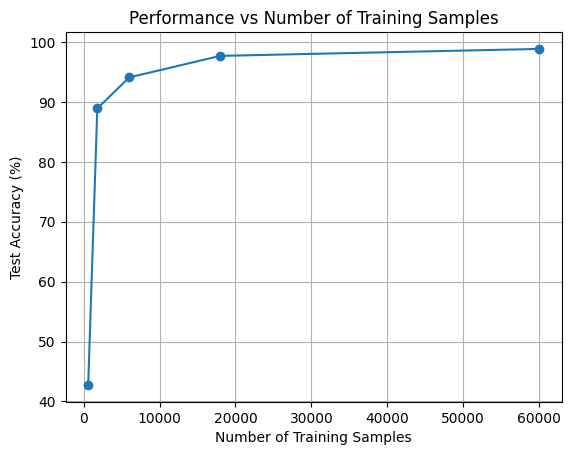

In [ ]:
import matplotlib.pyplot as plt

# Define function to load MNIST data
def load_data(batch_size, num_samples):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    indices = np.random.choice(len(trainset), num_samples, replace=False)
    trainset = torch.utils.data.Subset(trainset, indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

# Define function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs, device):
    model.train()
    model.to(device)
    criterion.to(device)
    
    for epoch in range(epochs):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch %d, Loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

# Define function to evaluate the model
def evaluate_model(model, testloader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy on test set: %.2f %%' % (accuracy))
    return accuracy

# Main code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 128
epochs = 5

num_training_samples = [600, 1800, 6000, 18000, 60000]
accuracies = []

for num_samples in num_training_samples:
    print(f"\nTraining with {num_samples} samples:")
    trainloader, testloader = load_data(batch_size, num_samples)
    model = LeNet()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    train_model(model, trainloader, criterion, optimizer, epochs, device)
    accuracy = evaluate_model(model, testloader, device)
    accuracies.append(accuracy)

# Plot results
plt.plot(num_training_samples, accuracies, marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Test Accuracy (%)')
plt.title('Performance vs Number of Training Samples')
plt.grid(True)
plt.show()

### 2.6

In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Define the Vision Transformer (ViT) model
class ViT(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=512, nhead=8, num_encoder_layers=6):
        super(ViT, self).__init__()
        self.d_model = d_model
        self.transformer_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=d_model, nhead=nhead), num_layers=num_encoder_layers)
        self.fc = nn.Linear(input_dim * d_model, num_classes)

    # Modify the forward method of the ViT model to handle input tensors of appropriate shape
    def forward(self, x):
    # Flatten the input tensor if it is not already flattened
        if len(x.shape) > 2:
            x = x.view(-1, 28*28)  # Assuming MNIST images are of size 28x28
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x    


# Define function to load MNIST data
def load_data(batch_size, num_samples):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    indices = torch.randperm(len(trainset))[:num_samples]
    trainset = torch.utils.data.Subset(trainset, indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    # Flatten the images
    trainloader.dataset.data = trainloader.dataset.dataset.data.view(len(trainloader.dataset), -1)
    testloader.dataset.data = testloader.dataset.data.view(len(testloader.dataset), -1)
    
    return trainloader, testloader



# Define function to train the model
def train_model(model, trainloader, criterion, optimizer, epochs, device):
    model.train()
    model.to(device)
    criterion.to(device)
    
    for epoch in range(epochs):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch %d, Loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

# Define function to evaluate the model
def evaluate_model(model, testloader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy on test set: %.2f %%' % (accuracy))
    return accuracy

# Main code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 128
epochs = 5

num_training_samples = [6000, 60000]
accuracies_vit = []

for num_samples in num_training_samples:
    print(f"\nTraining with {num_samples} samples:")
    trainloader, testloader = load_data(batch_size, num_samples)
    model = ViT(input_dim=28*28, num_classes=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    train_model(model, trainloader, criterion, optimizer, epochs, device)
    accuracy = evaluate_model(model, testloader, device)
    accuracies_vit.append(accuracy)

print("Accuracy with ViT model:", accuracies_vit)
